In [1]:
import math
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [90]:
class SnakeExtra:
    def __init__(self, B, c, l, rho, mesh_points=50):
        self.g = -9.8
        self.B = B
        self.c = c
        self.rho = rho
        self.lg = (-self.B / (self.rho * self.g)) ** (1 / 3)
        self.l = l
        self.x = np.linspace(0, 1, mesh_points)
        self.y = np.zeros((2, self.x.size))
        self.make_initial_guesses()

    def make_initial_guesses(self):
        """
        Initial parameter guesses for usual boundary conditions.
        """
        dy_ds = np.exp(-((self.x - 0.25) ** 2) / 0.010)
        y_guess = (
            np.pi / 2 * si.cumtrapz(dy_ds, self.x, initial=0) / si.trapz(dy_ds, self.x)
        )
        self.y[0, :] = y_guess  # np.pi/2*self.x**2
        # self.y[0, 0] = 0
        # self.y[0, -1] = np.pi / 2
        self.y[1, :] = dy_ds  # np.exp(-(self.x-0.2)**2/.010)
        # self.y[1, 0] = 0
        # self.y[1, -1] = 0

    def fun_k(self, x, y, p):
        l = p[0]
        c = p[1]
        dy0_dx = y[1]
        dy1_dx = (
            self.B * (-l / self.lg) ** 3 * x * np.cos(y[0]) / (self.B + c)
        )  # need -g
        dy_dx = np.vstack((dy0_dx, dy1_dx))
        return dy_dx

    def bc(self, ya, yb, p):
        res1 = ya[0]
        res2 = yb[0] - np.pi / 2
        res3 = yb[1]
        res4 = yb[0]
        residuals = np.array([res1, res2, res3, res4])
        return residuals

    def solve(self):
        self.sol = si.solve_bvp(
            fun=self.fun_k, bc=self.bc, x=self.x, y=self.y, p=[self.l, self.c]
        )
        self.l = self.sol.p[0]
        self.c = self.sol.p[1]
        self.x_pos = si.cumtrapz(self.l * np.cos(self.sol.y[0]), self.sol.x, initial=0)
        self.y_pos = si.cumtrapz(self.l * np.sin(self.sol.y[0]), self.sol.x, initial=0)

    def cost(self, alpha=0.5):
        height_term = self.y_pos[-1] / self.l
        self.height_cost = -alpha * height_term
        work_term = self.c / (2 * self.B) * si.trapz(self.sol.y[1] ** 2, self.sol.x)
        self.work_cost = (1 - alpha) * work_term
        cost = self.height_cost + self.work_cost
        return cost

In [91]:
snake = SnakeExtra(B=1, c=1, l=1, rho=1)

In [92]:
snake.solve()

In [93]:
snake.sol.message

'A singular Jacobian encountered when solving the collocation system.'

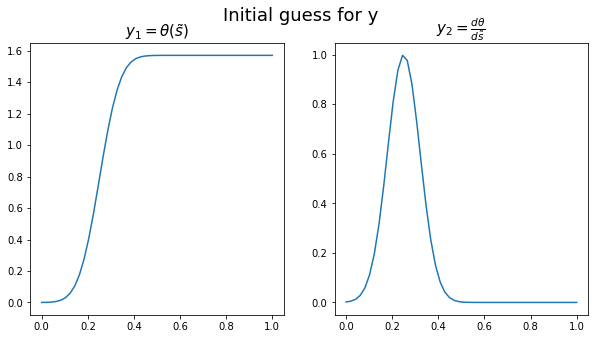

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle("Initial guess for y", fontsize=18)

ax[0].plot(snake.x, snake.y[0])
# ax[0].plot(
ax[0].set_title(r"$y_1=\theta(\tilde{s})$", fontsize=15)

ax[1].plot(snake.x, snake.y[1])
# ax[1].plot(snake.x, np.exp(-(snake.x-0.2)**2/.010))
ax[1].set_title(r"$y_2=\frac{d\theta}{d\tilde{s}}$", fontsize=15)

plt.show()